In [1]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
import os 
import sys 
import utils
%matplotlib inline

/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/kevinteng/anaconda3/lib/python3.6/site-package

---

# Hyperparameter

In [2]:
SHUFFLE_BUFFER = 4000
BATCH_SIZE = 16
lr = 0.0001
opt = tf.keras.optimizers.Adam(lr)
tfrecords_read_dir = '/home/kevinteng/Desktop/BRATS_stack/tfrecords/'

---

# Helper Functions

In [3]:
def dicesq(y_true, y_pred):
    '''
    Modified dice coefficient as refer to: https://arxiv.org/abs/1606.04797
    :param y_true: Ground truth
    :param y_pred: Prediction from the model
    :return: Modified dice coefficient
    '''
    nmr = 2*tf.reduce_sum(y_true*y_pred)
    dnmr = tf.reduce_sum(y_true**2) + tf.reduce_sum(y_pred**2) + tf.keras.backend.epsilon()
    return (nmr / dnmr)

def dicesq_loss(y_true, y_pred):
    '''
    Modified dice coefficient loss
    :param y_true: Ground truth
    :param y_pred: Prediction from the model
    '''
    return 1- dicesq(y_true, y_pred)

def dice_coef(y_true, y_pred):
    '''
    Dice coefficient for tensorflow
    '''
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + tf.keras.backend.epsilon()) / \
(tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + tf.keras.backend.epsilon())

def dice_coe(target, output, axis=(1, 2, 3), smooth=1e-5):
    """Soft dice (Sørensen or Jaccard) coefficient for comparing the similarity
    of two batch of data, usually be used for binary image segmentation
    i.e. labels are binary. The coefficient between 0 to 1, 1 means totally match.

    Parameters
    -----------
    output : Tensor
        A distribution with shape: [batch_size, ....], (any dimensions).
    target : Tensor
        The target distribution, format the same with `output`.
    loss_type : str
        ``jaccard`` or ``sorensen``, default is ``jaccard``.
    axis : tuple of int
        All dimensions are reduced, default ``[1,2,3]``.
    smooth : float
        This small value will be added to the numerator and denominator.
            - If both output and target are empty, it makes sure dice is 1.
            - If either output or target are empty (all pixels are background), dice = ```smooth/(small_value + smooth)``, then if smooth is very small, dice close to 0 (even the image values lower than the threshold), so in this case, higher smooth can have a higher dice.

    Examples
    ---------
    >>> import tensorlayer as tl
    >>> outputs = tl.act.pixel_wise_softmax(outputs)
    >>> dice_loss = 1 - tl.cost.dice_coe(outputs, y_)

    References
    -----------
    - `Wiki-Dice <https://en.wikipedia.org/wiki/Sørensen–Dice_coefficient>`__
    https://tensorlayer.readthedocs.io/en/latest/_modules/tensorlayer/cost.html
    """
    inse = tf.reduce_sum(output * target, axis=axis)
    l = tf.reduce_sum(output * output, axis=axis)
    r = tf.reduce_sum(target * target, axis=axis)
    dice = (2. * inse + smooth) / (l + r + smooth)
    dice = tf.reduce_mean(dice)
    return dice

def dice_coef_loss(y_true, y_pred):
    '''
    Dice coefficient loss for IOU
    '''
    return 1-dice_coe(y_true, y_pred)

def plot_comparison(input_img, caption, n_row=1, n_col=2, figsize=(10, 10), cmap = 'gray'):
    '''
    Plot comparison of multiple image but only in column wise!
    :param input_img: Input image list
    :param caption: Input caption list
    :param IMG_SIZE: Image size
    :param n_row: Number of row is 1 by DEFAULT
    :param n_col: Number of columns
    :param figsize: Figure size during plotting
    :return: Plot of (n_row, n_col)
    '''
    print()
    assert len(caption) == len(input_img), "Caption length and input image length does not match"
    assert len(input_img) == n_col, "Error of input images or number of columns!"

    fig, axes = plt.subplots(n_row, n_col, figsize=figsize)
    fig.subplots_adjust(hspace=0.4, wspace=0.4, right=0.7)

    for i in range(n_col):
        axes[i].imshow(np.squeeze(input_img[i]), cmap= cmap)
        axes[i].set_xlabel(caption[i])
        axes[i].set_xticks([])
        axes[i].set_yticks([])

    plt.tight_layout()
    plt.show()

----

# Model

In [4]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import InputLayer, Conv2DTranspose, Activation, BatchNormalization
from coord_conv import CoordConv

def conv_block(x_in, filters, batch_norm = False, kernel_size=(3,3)):
    x = Conv2D(filters, kernel_size, padding='same')(x_in)
    if batch_norm==True:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    if batch_norm==True:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def coordconv_block(x_in, x_dim, y_dim, filters, batch_norm = False, kernel_size=(3,3), with_r = False):
    x = Conv2D(filters, kernel_size, padding='same')(x_in)
    if batch_norm==True:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = CoordConv(x_dim, y_dim, with_r, filters, kernel_size, padding='same')(x)
    if batch_norm==True:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def conv_2d(x_in, filters, batch_norm = False, kernel_size=(3,3),acti ='relu'):
    x = Conv2D(filters, kernel_size, padding='same')(x_in)
    if batch_norm==True:
        x=BatchNormalization()(x)
    x= Activation(acti)(x)
    return x
    
def pool(x_in, pool_size=(2, 2), type='Max'):
    if type=='Max':
        p = MaxPooling2D(pool_size)(x_in)
    return p

def up(x_in, filters, merge, batch_norm = False, size=(2,2)):
    u = UpSampling2D(size)(x_in)
    conv = conv_2d(u, filters, batch_norm)
    concat = tf.concat([merge, conv],axis=-1)
    return concat
    
def Unet_model(input_layer):
    #downsampling
    conv1 = coordconv_block(input_layer, x_dim=240, y_dim=240, filters=64)
    pool1 = pool(conv1)
    
    conv2 = conv_block(pool1, filters=128)
    pool2 = pool(conv2)
    
    conv3 = conv_block(pool2, filters=256, batch_norm = True)
    pool3 = pool(conv3)
    
    conv4 = conv_block(pool3, filters=512)
    pool4 = pool(conv4)
    
    conv5 = conv_block(pool4, filters=1024, batch_norm = True)
    
    #upsampling
    up1 = up(conv5,filters=512, merge=conv4)
    conv6 = coordconv_block(up1, x_dim=30, y_dim=30, filters=512)
    
    up2 = up(conv6, filters=256, merge=conv3, batch_norm = True)
    conv7 = conv_block(up2, filters=256, batch_norm = True)
    
    up3 = up(conv7, filters=128, merge=conv2)
    conv8 = conv_block(up3, filters=128)
    
    up4 = up(conv8, filters=64, merge=conv1, batch_norm = True)
    conv9 = conv_block(up4, filters=64, batch_norm = True)
    
    #on paper filters = 2
    output_layer = conv_2d(conv9, filters=1, kernel_size=(1,1), acti='sigmoid')
    
    return output_layer

In [5]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input

input_layer = Input(shape=(240,240,1))
Unet = Model(input_layer, Unet_model(input_layer))

In [6]:
#to do..Sensitivity
bxent = tf.keras.losses.BinaryCrossentropy()
@tf.function
def train_fn(image, label):
    with tf.GradientTape() as tape:
        model_output = Unet(image)
        loss = bxent(label, model_output)
    gradients = tape.gradient(loss, Unet.trainable_variables)
    opt.apply_gradients(zip(gradients, Unet.trainable_variables))
    
    return model_output, loss, gradients

Epochs  1

HGG_lbl_complete_tumor_HGG_training_MR_Flair.tfrecords




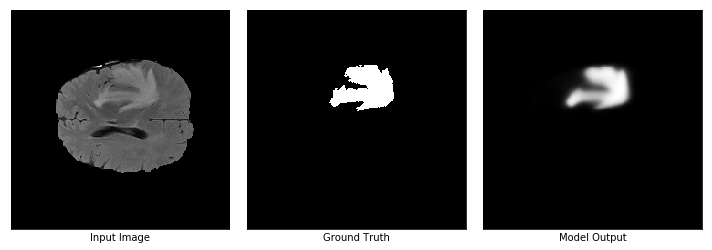

Steps: 1000, Loss:0.0060959309339523315, Dice Score:0.7699542045593262
Gradient min:-0.0015023277373984456, max:0.002158417133614421



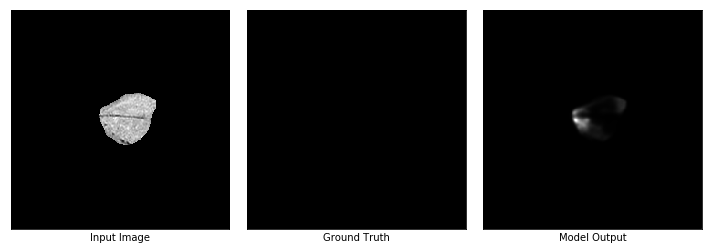

Steps: 2000, Loss:0.0064655630849301815, Dice Score:1.9656257066458238e-08
Gradient min:-0.00335329188965261, max:0.002037019468843937

Average Dice Coefficient: 0.6480095386505127
HGG_lbl_complete_tumor_HGG_training_MR_T1.tfrecords




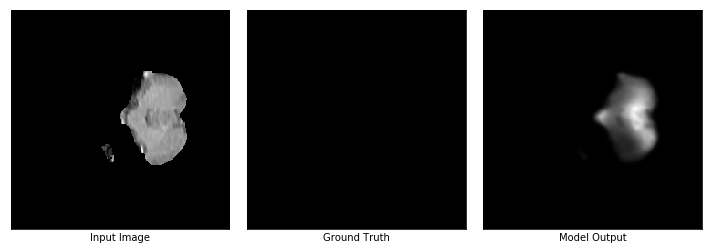

Steps: 3000, Loss:0.02405600994825363, Dice Score:6.973112309793805e-09
Gradient min:-0.008809907361865044, max:0.011470530182123184



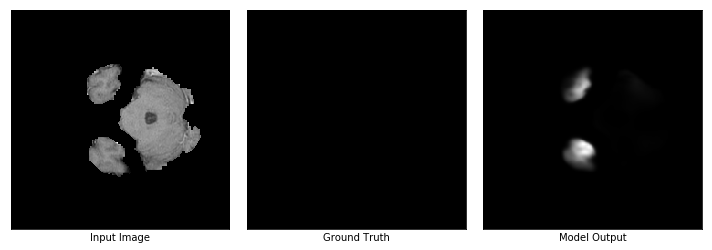

Steps: 4000, Loss:0.027467502281069756, Dice Score:1.7367352000974279e-09
Gradient min:-0.00549249118193984, max:0.01098537351936102

Average Dice Coefficient: 0.5719786882400513
HGG_lbl_complete_tumor_HGG_training_MR_T1c.tfrecords




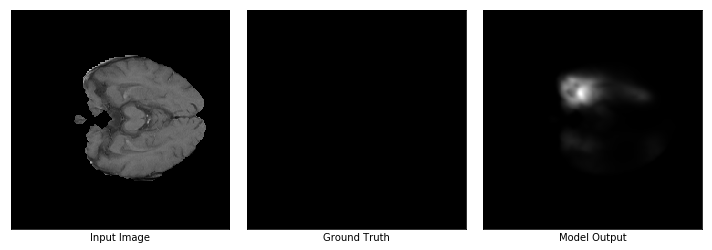

Steps: 5000, Loss:0.008599077351391315, Dice Score:5.829104421373188e-10
Gradient min:-0.004435457289218903, max:0.0018377389060333371



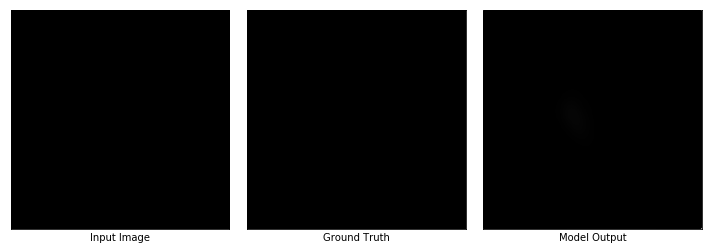

Steps: 6000, Loss:0.0069643305614590645, Dice Score:2.4127086817316012e-06
Gradient min:-0.0034318682737648487, max:0.004088199231773615

Average Dice Coefficient: 0.6206283569335938
HGG_lbl_complete_tumor_HGG_training_MR_T2.tfrecords




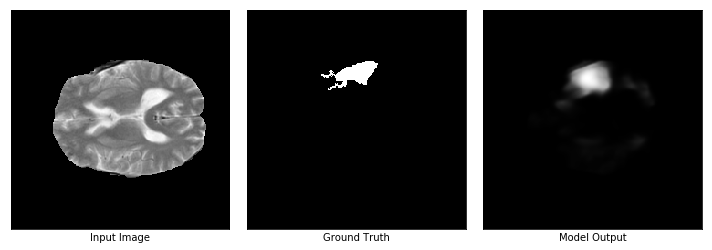

Steps: 7000, Loss:0.010347703471779823, Dice Score:0.4975857734680176
Gradient min:-0.002438749186694622, max:0.0032830366399139166



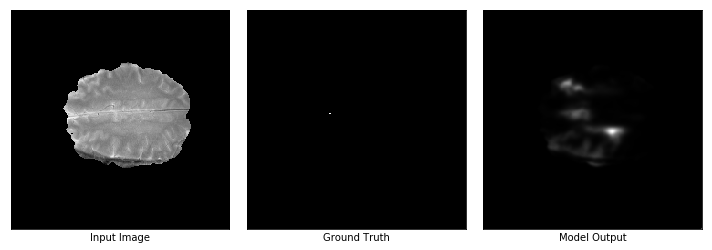

Steps: 8000, Loss:0.007090286817401648, Dice Score:0.0007928919512778521
Gradient min:-0.0037333390209823847, max:0.0017677602590993047

Average Dice Coefficient: 0.6606451869010925
Epochs  2

HGG_lbl_complete_tumor_HGG_training_MR_Flair.tfrecords




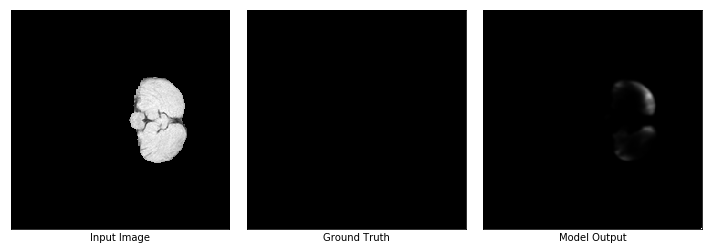

Steps: 1000, Loss:0.005171726457774639, Dice Score:1.1227310778849642e-06
Gradient min:-0.0012941646855324507, max:0.0026338978204876184



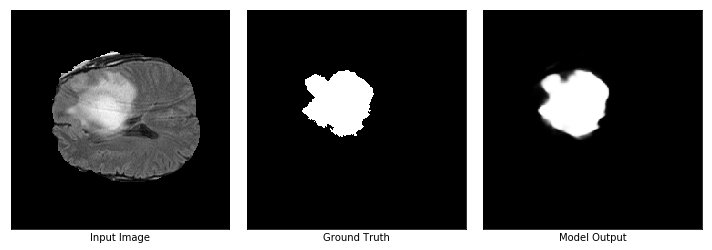

Steps: 2000, Loss:0.005679771304130554, Dice Score:0.9511313438415527
Gradient min:-0.00209571560844779, max:0.0024393186904489994

Average Dice Coefficient: 0.7003072500228882
HGG_lbl_complete_tumor_HGG_training_MR_T1.tfrecords




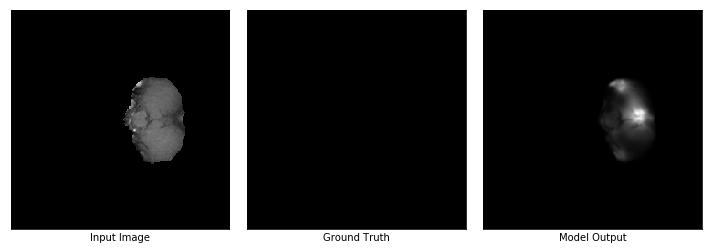

Steps: 3000, Loss:0.012526319362223148, Dice Score:3.672430537449145e-08
Gradient min:-0.008059646002948284, max:0.014176420867443085



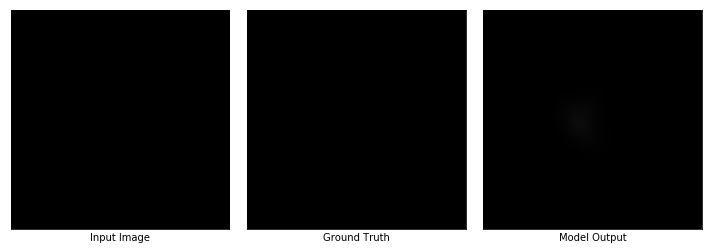

Steps: 4000, Loss:0.008883423171937466, Dice Score:0.0002258865861222148
Gradient min:-0.0018671073485165834, max:0.0020103715360164642

Average Dice Coefficient: 0.705752968788147
HGG_lbl_complete_tumor_HGG_training_MR_T1c.tfrecords




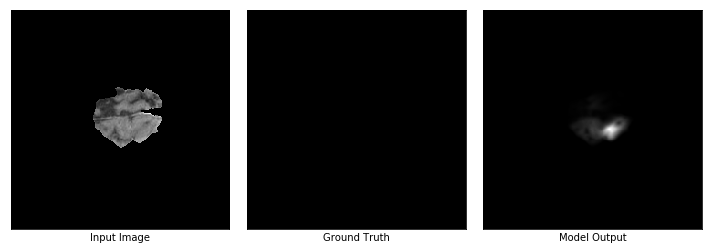

Steps: 5000, Loss:0.009064286947250366, Dice Score:4.51116521915651e-09
Gradient min:-0.0036307123955339193, max:0.0045308638364076614



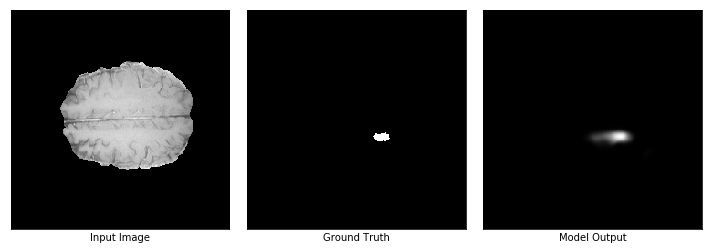

Steps: 6000, Loss:0.00647504348307848, Dice Score:0.4277837574481964
Gradient min:-0.003283717902377248, max:0.0015817254316061735

Average Dice Coefficient: 0.7214846611022949
HGG_lbl_complete_tumor_HGG_training_MR_T2.tfrecords




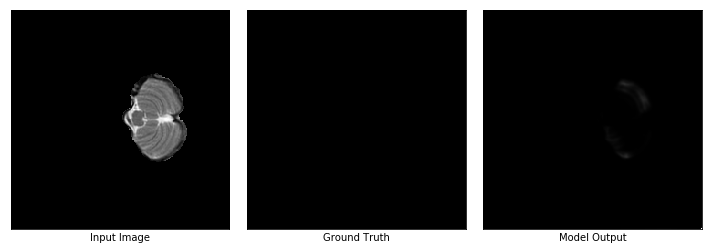

Steps: 7000, Loss:0.009530778042972088, Dice Score:3.522330871419399e-06
Gradient min:-0.004618900828063488, max:0.009183908812701702



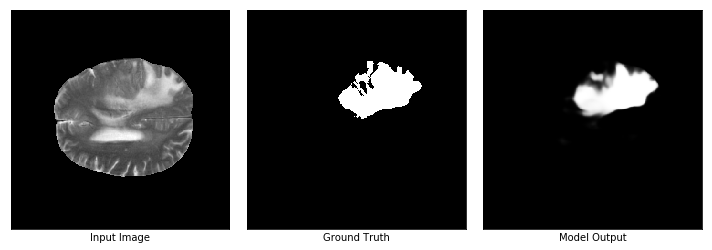

Steps: 8000, Loss:0.006642053835093975, Dice Score:0.8862382173538208
Gradient min:-0.001459341263398528, max:0.0012685341062024236

Average Dice Coefficient: 0.7369679808616638
Epochs  3

HGG_lbl_complete_tumor_HGG_training_MR_Flair.tfrecords




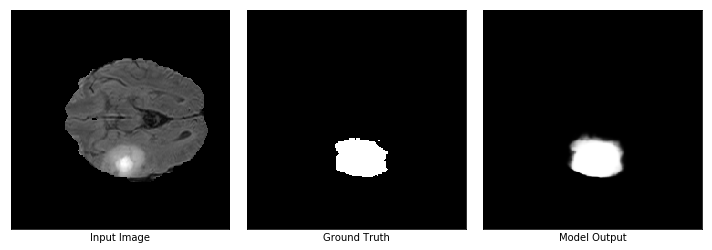

Steps: 1000, Loss:0.002720697084441781, Dice Score:0.9339072704315186
Gradient min:-0.0009945306228473783, max:0.0027558011934161186



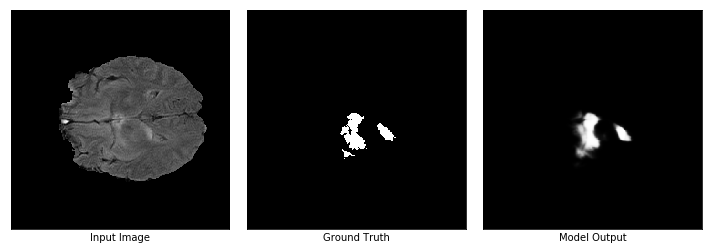

Steps: 2000, Loss:0.005413717124611139, Dice Score:0.7856926918029785
Gradient min:-0.001752920332364738, max:0.0008226072532124817

Average Dice Coefficient: 0.754023551940918
HGG_lbl_complete_tumor_HGG_training_MR_T1.tfrecords




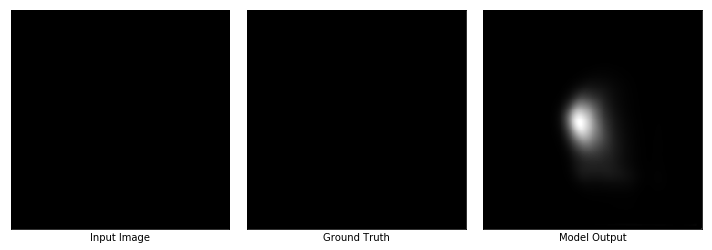

Steps: 3000, Loss:0.0036958365235477686, Dice Score:3.2900425139814615e-05
Gradient min:-0.002458472503349185, max:0.00264631281606853



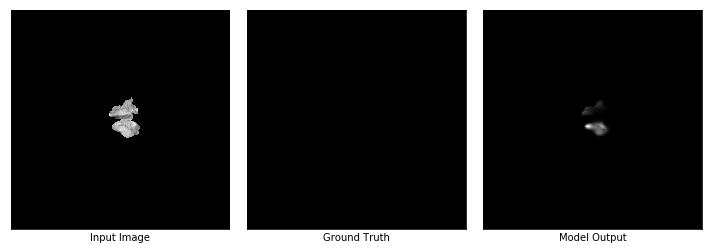

Steps: 4000, Loss:0.008197590708732605, Dice Score:2.3339875099281926e-07
Gradient min:-0.004748546052724123, max:0.0036728433333337307

Average Dice Coefficient: 0.7606807351112366
HGG_lbl_complete_tumor_HGG_training_MR_T1c.tfrecords




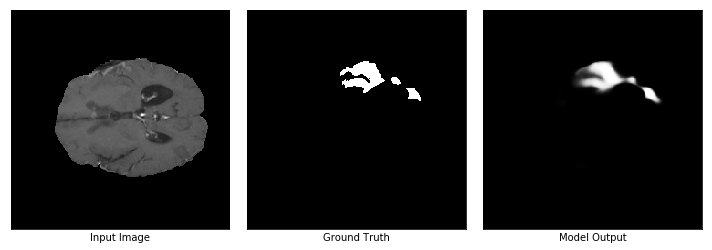

Steps: 5000, Loss:0.005121507681906223, Dice Score:0.7905526161193848
Gradient min:-0.003075881628319621, max:0.0025833393447101116



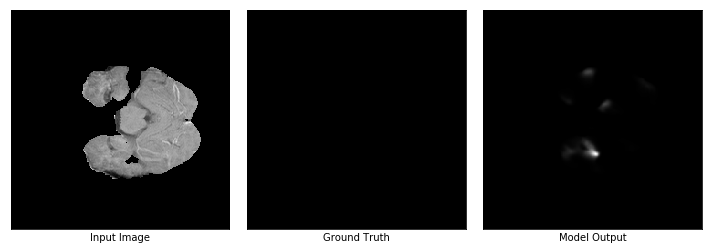

Steps: 6000, Loss:0.0033958163112401962, Dice Score:7.609767749272578e-08
Gradient min:-0.005872748792171478, max:0.003244338557124138

Average Dice Coefficient: 0.7699887156486511
HGG_lbl_complete_tumor_HGG_training_MR_T2.tfrecords




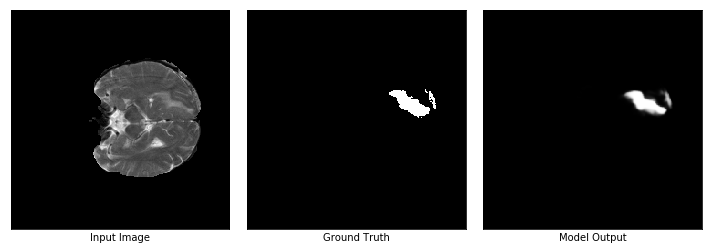

Steps: 7000, Loss:0.0035526014398783445, Dice Score:0.8184210062026978
Gradient min:-0.0005385830882005394, max:0.0005571174551732838



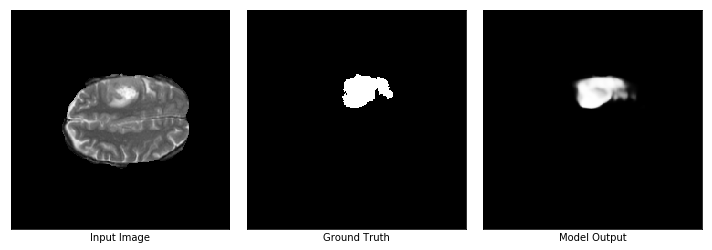

Steps: 8000, Loss:0.007554445415735245, Dice Score:0.8554727435112
Gradient min:-0.0017117296811193228, max:0.0029145064763724804

Average Dice Coefficient: 0.7789884805679321
Epochs  4

HGG_lbl_complete_tumor_HGG_training_MR_Flair.tfrecords




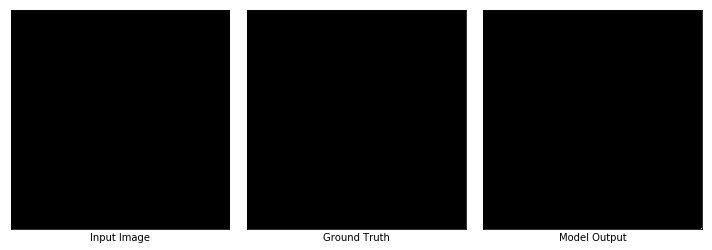

Steps: 1000, Loss:0.003841046243906021, Dice Score:0.00026090056053362787
Gradient min:-0.0014445269480347633, max:0.0009076239657588303



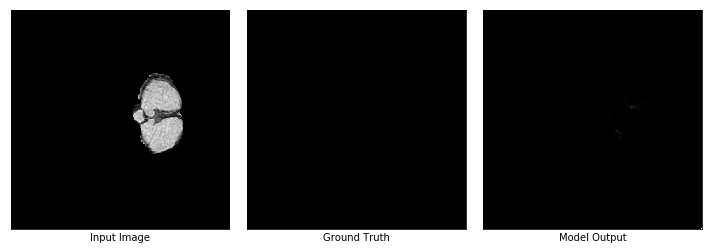

Steps: 2000, Loss:0.0037825738545507193, Dice Score:0.0007320361910387874
Gradient min:-0.0014065514551475644, max:0.0027879890985786915

Average Dice Coefficient: 0.7887336015701294
HGG_lbl_complete_tumor_HGG_training_MR_T1.tfrecords



In [ ]:
epochs = 1
max_epochs = 20
predicted_img = []
groundtruth_img = []
loss_list = []
dice_list = []
while epochs <= max_epochs:
    print("Epochs {:2d}".format(epochs))
    print()
    steps = 1
    for tf_re in sorted(os.listdir(tfrecords_read_dir)):
        print(tf_re)
        print()
        tf_dir = os.path.join(tfrecords_read_dir+tf_re)
        dataset = utils.parse_tfrecord(tf_dir).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE)
        for image, label in dataset:
            image = tf.reshape(image, [-1, 240, 240, 1]) #(batch_size, img_size, img_size, channel)
            label = tf.reshape(label, [-1, 240, 240, 1]) #(batch_size, img_size, img_size, channel)
            img_seg, loss, gradients = train_fn(image, label) #training function 
            dice_score = dice_coef(label, img_seg)
            
            dice_list.append(dice_score) #append dice score for every every images
            
            #output
            if steps%1000==0:
                input_img = [image[0], label[0], img_seg[0]]
                caption = ['Input Image', 'Ground Truth', 'Model Output']
                plot_comparison(input_img, caption, n_col = 3)
                
                predicted_img.append(img_seg[0])
                groundtruth_img.append(label[0])
                loss_list.append(loss)
                dice_coe = dice_coef(label[0], img_seg[0])
                print("Steps: {}, Loss:{}, Dice Score:{}".format(steps, loss, dice_coe))
                print("Gradient min:{}, max:{}".format(np.min(gradients[0]), np.max(gradients[0])))
            steps+=1
        print()
        print("Average Dice Coefficient: {}".format(np.mean(np.array(dice_list))))
    epochs+=1 

---

# Model Summary

In [ ]:
# Unet.summary()